In [6]:
import sklearn.model_selection
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import torch
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy
plt.style.use('seaborn-whitegrid')

In [3]:
# Gets data into dataframe, divides everything by 10 (max value) to get all numbers between -1 and 1
# This data was gathered using the Sabberstone Hearthstone simulator. We didn't include that code because the repo
# is fairly large and we felt that the data sourcing wasn't neccesarily the point of this project.

data = pandas.read_csv("./data/hsdata.csv")
data_list = data.values.tolist()
feature_matrix = [arr[:-1] for arr in data_list]
feature_matrix = [[ele / 10 for ele in arr] for arr in feature_matrix]
target_array = [arr[-1] for arr in data_list]

Text(0.5, 1.0, 'Explained Variance')

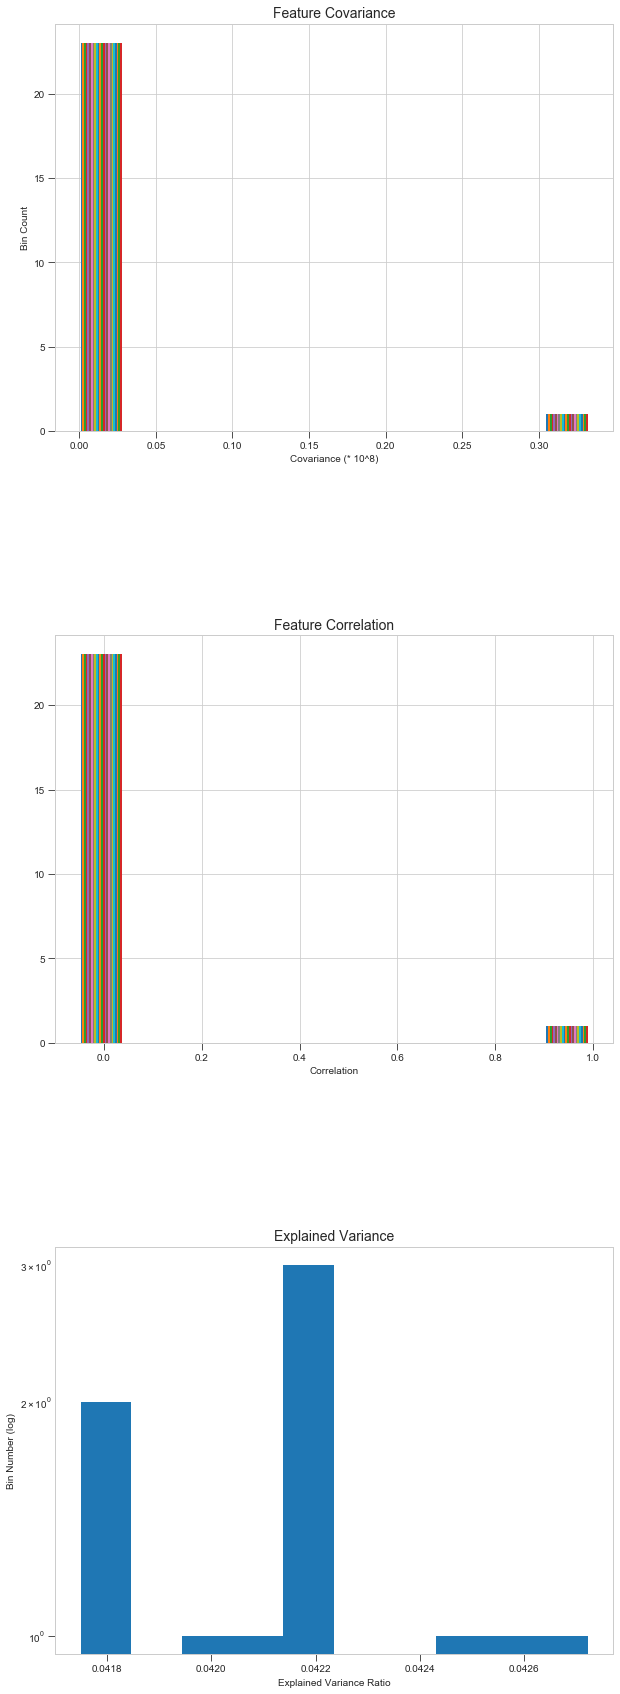

In [163]:
# Performs correlation, covariance, and explained variance analysis

fig = plt.figure(figsize=(10, 30))
X = feature_matrix

cov_arr = np.cov(np.transpose(X))
pca = PCA(n_components=10)
pca.fit(X)

ax1 = plt.subplot(311)
ax1.hist(np.triu(cov_arr))
ax1.tick_params(which='major', length=7)
ax1.set_xlabel('Covariance (* 10^8)')
ax1.set_ylabel('Bin Count')
ax1.set_title('Feature Covariance', fontsize=14)

correlation_arr = np.corrcoef(cov_arr)
ax2 = plt.subplot(312)
ax2.hist(np.triu(correlation_arr))
ax2.tick_params(which='major', length=7)
ax2.set_xlabel('Correlation')
ax2.set_title('Feature Correlation', fontsize=14)

plt.subplots_adjust(hspace=0.5)
ax3 = plt.subplot(313)
ax3 = plt.gca()
ax3.set_yscale('log')
ax3.hist(pca.explained_variance_ratio_)
ax3.set_xlabel('Explained Variance Ratio')
ax3.set_ylabel('Bin Number (log)')
ax3.grid(False)
ax3.tick_params(which='major', length=7)
ax3.set_title('Explained Variance', fontsize=14)



In [174]:
sizes = [len(feature_matrix[0]), 1]

# The neural net definition
# Currently using a network with 1 linear layer, a PReLU layer, and a dropout layer

class Net(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(sizes[0], sizes[1])
        self.do1 = torch.nn.Dropout()
        self.ac1 = torch.nn.PReLU()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        a2 = self.ac1(a1)
        return self.do1(a2)

model = Net()

# Neural net parameters
learning_rate = 1e-5
epochs = 1500
mini_batch_size = 100
criterion = torch.nn.L1Loss()

# Optimization wrapper
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(feature_matrix, target_array, test_size=0.8, train_size=0.2)
X_train = torch.tensor(X_train)
y_train = torch.tensor(np.array(y_train).reshape(-1, 1))
# Train
for t in range(epochs):
    
    # Randomly permutes the row indices
    permutation = torch.randperm(len(X_train))
    model.train()
    
    # Iterates over mini-batches
    for k in np.arange(0, len(X_train), mini_batch_size):
        
        mini_batch_indices = permutation[k:k+mini_batch_size]
        x_ = X_train[mini_batch_indices, :]
        y_ = y_train[mini_batch_indices, :]
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x_.float())

        # Compute loss
        loss = criterion(y_pred.float(), y_.float())

        # Backward pass
        loss.backward()

        optimizer.step()
        
        
    # Print progress (here evaluating on all the data so we can compare)
    if t % 10 == 0:
        print(t, "train:", loss.item())
        
# Formatting the true and predicted arrays for analysis
y_true = np.array(y_test).reshape(-1)
y_pred = model(torch.tensor(X_test).float()).data.numpy().reshape(-1)
y_true = y_true.reshape(y_true.shape[0])
y_pred = y_pred.reshape(y_pred.shape[0])

# Reformat the predictions to be either 0 or 1
y_pred = (y_pred >= 0.5).astype(int)

num_correct = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_true[i]:
        num_correct += 1
print(f'Accuracy using neural network: {num_correct / len(y_pred)}')

0 train: 0.41081035137176514
10 train: 0.3268741965293884
20 train: 0.3993486762046814
30 train: 0.39722782373428345
40 train: 0.3822441101074219
50 train: 0.44245460629463196
60 train: 0.38224756717681885
70 train: 0.3806130290031433
80 train: 0.32718273997306824
90 train: 0.43645381927490234
100 train: 0.41588982939720154
110 train: 0.35120654106140137
120 train: 0.4100419878959656
130 train: 0.3866139352321625
140 train: 0.44803541898727417
150 train: 0.37373054027557373
160 train: 0.43351855874061584
170 train: 0.4454694092273712
180 train: 0.36661338806152344
190 train: 0.3551846444606781
200 train: 0.3652881681919098
210 train: 0.3908059597015381
220 train: 0.37916243076324463
230 train: 0.346953421831131
240 train: 0.41929009556770325
250 train: 0.3842592239379883
260 train: 0.42591822147369385
270 train: 0.3339799642562866
280 train: 0.3707018196582794
290 train: 0.32972216606140137
300 train: 0.4900195002555847
310 train: 0.40861180424690247
320 train: 0.3666052520275116
330 t

In [177]:
# Prints out the feature weights
for i in range(len(weights)):
    print(f'{data.columns[i]}: {weights[i]:.20f}')


HERO_HEALTH_REDUCED: 0.02978996187448501587
HERO_ATTACK_REDUCED: -0.00318665639497339725
WEAPON_DURABILITY_REDUCED: 0.00348940002731978893
MINION_HEALTH_REDUCED: -0.00400655437260866165
MINION_ATTACK_REDUCED: 0.04111846536397933960
MINION_KILLED: 0.11956916004419326782
MINION_APPEARED: -0.01585331372916698456
SECRET_REMOVED: 0.01084957178682088852
MANA_REDUCED: -0.12021212279796600342
M_HEALTH: -0.00146640429738909006
M_ATTACK: 0.00578224333003163338
M_HAS_CHARGE: 0.00287493830546736717
M_HAS_DEAHTRATTLE: 0.02130169607698917389
M_HAS_DIVINE_SHIELD: -0.00203602435067296028
M_HAS_LIFE_STEAL: 0.01017116382718086243
M_HAS_STEALTH: -0.00217816513031721115
M_HAS_TAUNT: 0.01499202288687229156
M_HAS_WINDFURY: 0.01702820882201194763
M_IS_RUSH: -0.00332036474719643593
M_MANA_COST: 0.42425787448883056641
M_POISONOUS: 0.00005312222856446169
M_SILENCED: 0.00092798698460683227
M_SUMMONED: 0.46059826016426086426
M_CANT_BE_TARGETED_BY_SPELLS: -0.00093383796047419310
